In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define paths
base_dir = '/content/drive/MyDrive/database3'
classes = ['walking', 'vandalism', 'fighting']

In [ ]:
def process_video(video_path, target_frames=30, resize_dim=(64, 64)):
    """
    Extract `target_frames` consecutive frames from the center of the video.
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < target_frames:
        start_frame = 0
    else:
        start_frame = (total_frames - target_frames) // 2  # center

    frames = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    for _ in range(target_frames):
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, resize_dim)
            frames.append(frame)
        else:
            break

    cap.release()

    if len(frames) == target_frames:
        return np.array(frames) / 255.0
    else:
        return None


In [ ]:
def load_dataset(base_dir, classes, max_samples_per_class=200, test_size=0.2):
    X = []
    y = []
    class_labels = []

    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name, 'train')
        video_files = [f for f in os.listdir(class_dir) if f.endswith('.mp4') or f.endswith('.avi')][:max_samples_per_class]

        print(f"Processing {class_name}...")
        for video_file in tqdm(video_files):
            video_path = os.path.join(class_dir, video_file)
            frames = process_video(video_path)
            if frames is not None:
                X.append(frames)
                y.append(class_name)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Split dataset
    X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=test_size, random_state=42)

    return np.array(X_train), np.array(X_val), y_train, y_val, le

# Load data with limited samples per class to avoid memory issues
X_train, X_val, y_train, y_val, label_encoder = load_dataset(base_dir, classes, max_samples_per_class=150)

Processing walking...


100%|██████████| 80/80 [00:44<00:00,  1.81it/s]


Processing vandalism...


100%|██████████| 27/27 [00:38<00:00,  1.41s/it]


Processing fighting...


100%|██████████| 80/80 [00:49<00:00,  1.61it/s]


In [ ]:
def create_model(input_shape, num_classes):
    model = Sequential()

    # CNN part - TimeDistributed to apply same CNN to each frame
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    # LSTM part
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Get input shape (frames, height, width, channels)
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])
num_classes = y_train.shape[1]

model = create_model(input_shape, num_classes)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 62, 62, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 62, 62, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 30, 31, 31, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 30, 31, 31, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 30, 29, 29, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 29, 29, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 14, 14, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 30, 14, 14, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 30, 12, 12, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 30, 12, 12, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 30, 6, 6, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 30, 6, 6, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 30, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │       606,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 645,219 (2.46 MB)

 Trainable params: 644,995 (2.46 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.9963 - loss: 0.0544 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 4.0000e-05
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.9981 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 4.0000e-05
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.9884 - loss: 0.0328 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 4.0000e-05
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.9841 - loss: 0.0424 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 4.0000e-05
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 4.0000e-05
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.9988 - loss: 0.0348 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 4.0000e-05
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 

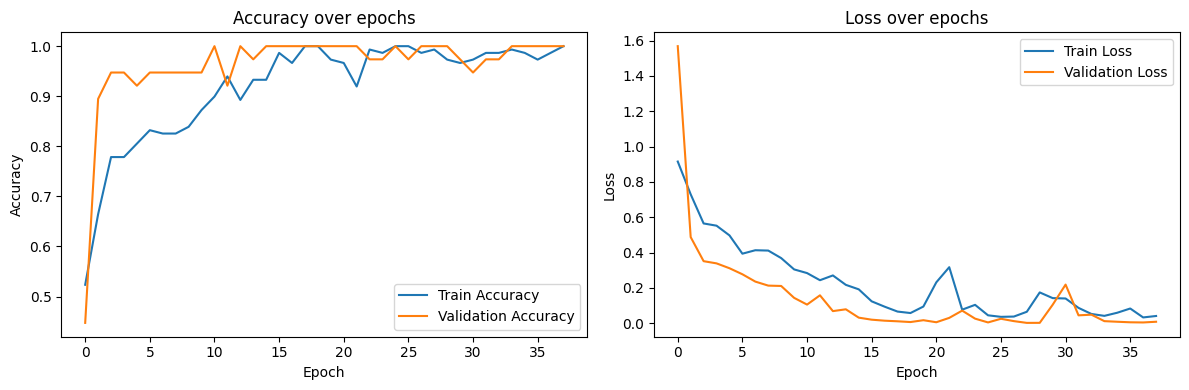

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


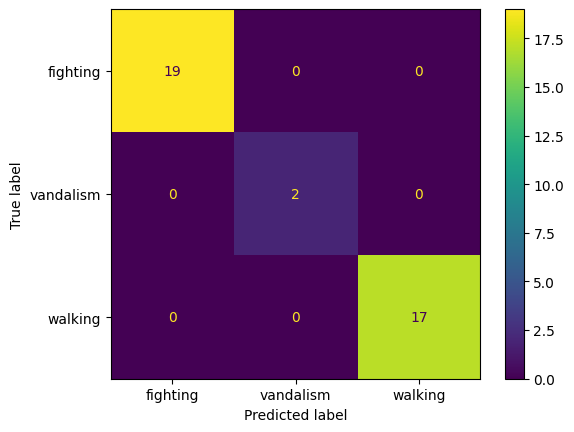

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()


In [ ]:
def load_test_dataset(base_dir, classes, label_encoder, max_samples_per_class=50):
    X_test = []
    y_test = []

    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name, 'test')
        video_files = [f for f in os.listdir(class_dir) if f.endswith('.mp4') or f.endswith('.avi')][:max_samples_per_class]

        print(f"Processing test {class_name}...")
        for video_file in tqdm(video_files):
            video_path = os.path.join(class_dir, video_file)
            frames = process_video(video_path)
            if frames is not None:
                X_test.append(frames)
                y_test.append(class_name)

    y_test_encoded = label_encoder.transform(y_test)
    y_test_categorical = to_categorical(y_test_encoded)

    return np.array(X_test), y_test_categorical, y_test

X_test, y_test, y_test_labels = load_test_dataset(base_dir, classes, label_encoder)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
# Initialize label encoder
label_encoder = LabelEncoder()
label_encoder.fit(['walking','vandalism','fighting'])  # Must match training order
def predict_activity(model, video_path, label_encoder):
    frames = process_video(video_path)
    if frames is None:
        return "Error processing video"

    # Add batch dimension
    frames = np.expand_dims(frames, axis=0)

    # Predict
    pred = model.predict(frames)
    class_idx = np.argmax(pred)
    class_label = label_encoder.inverse_transform([class_idx])[0]

    # Classify as normal or suspicious
# Classify as normal or suspicious
    if class_label == 'fighting' or class_label == 'vandalism':
        return f"Suspicious activity: {class_label.capitalize()}"
    else:
        return "Normal activity"


# Example prediction
test_video_path = '/content/drive/MyDrive/database3/walking/test/person25_walking_d4_uncomp.avi'  # Replace with actual path
result = predict_activity(model, test_video_path, label_encoder)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Normal activity


In [ ]:
# Define the path to save model
save_path = '/content/drive/MyDrive/suspicious_activity_model.keras'

# Save the model
model.save(save_path)

print(f"Model saved at: {save_path}")


Model saved at: /content/drive/MyDrive/suspicious_activity_model.keras


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/suspicious_activity_model.keras')
